In [2]:
import SemanticSegmentationModules as ssm 
from utils.Trainer import Trainer
from utils.Metrics import SemanticSegMetrics

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import albumentations as A
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
data_path = 'drive/MyDrive/CVPPPSegmData/'
split = pd.read_csv(data_path + 'split.csv')
split.head()

,split,img_path,sem_path,inst_path
0,train,data/A1/plant001_rgb.png,data/A1/plant001_fg.png,data/A1/plant001_label.png
1,train,data/A1/plant005_rgb.png,data/A1/plant005_fg.png,data/A1/plant005_label.png
2,train,data/A1/plant006_rgb.png,data/A1/plant006_fg.png,data/A1/plant006_label.png
3,train,data/A1/plant007_rgb.png,data/A1/plant007_fg.png,data/A1/plant007_label.png
4,train,data/A1/plant008_rgb.png,data/A1/plant008_fg.png,data/A1/plant008_label.png


Сформируем датасеты

In [7]:
transform_train = A.Compose([
                A.Resize(400, 400),
                A.GaussNoise(p=0.5, mean=0),
                A.ShiftScaleRotate(p=0.8, rotate_limit=180, shift_limit_x=0.07, shift_limit_y=0.1),
                A.RandomBrightnessContrast(p=0.9)
            ]) 

transform_test = A.Compose([
                A.Resize(400, 400)
            ]) 

In [ ]:
train_dataset = ssm.LeavesSemSegDataset(data_path, split[split.split == 'train'], transform=transform_train)
val_dataset = ssm.LeavesSemSegDataset(data_path, split[split.split == 'dev'].reset_index(drop=True), transform=transform_test)
test_dataset = ssm.LeavesSemSegDataset(data_path, split[split.split == 'test'].reset_index(drop=True), transform=transform_test)

Обучим семантическую сегментацию.

epoch: 150
train loss: 0.0003597675848835975
val dice: 0.9588433579001611
val mse: 0.0002104918206376689


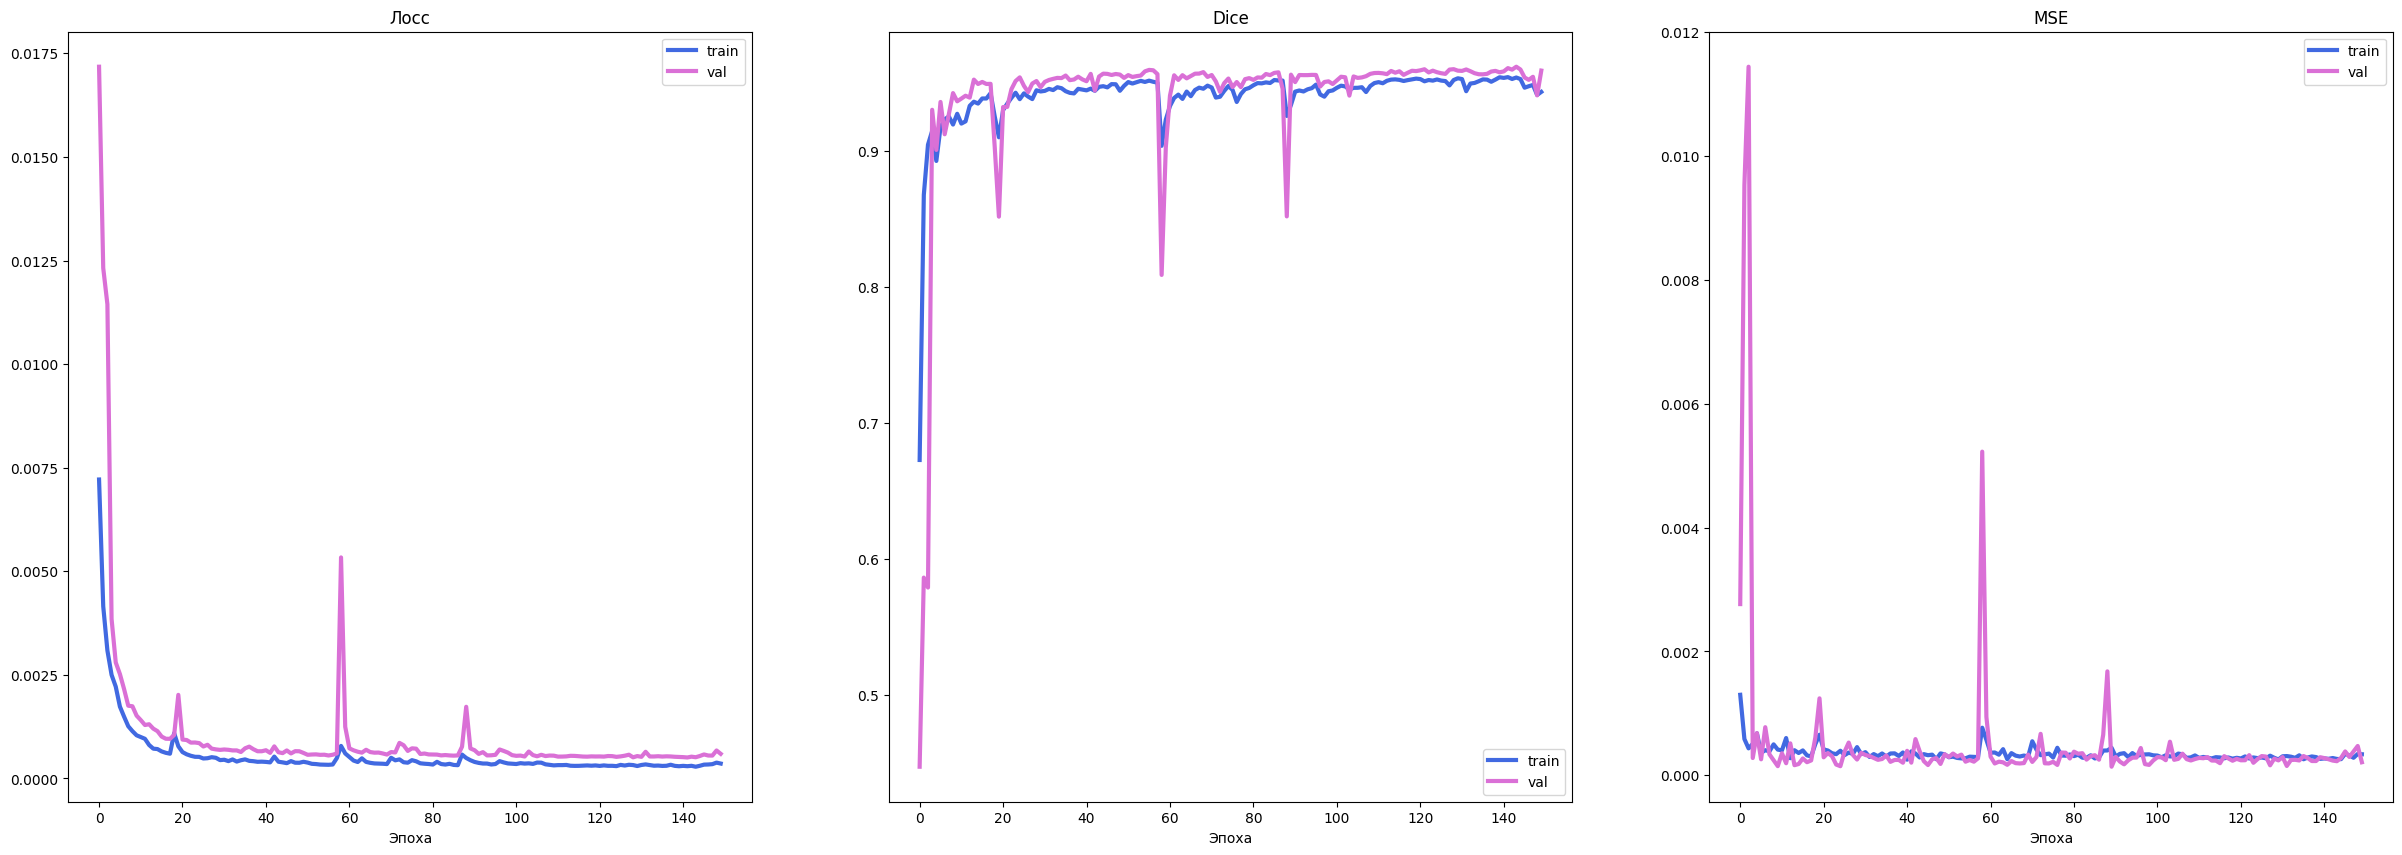

In [ ]:
device = "cuda"
model = ssm.UNet(3, 1, 10)
model.to(device)

params = {
    "batch_size": 64,
    "num_workers": 1,
    "device": device,
    "lr": 2e-3,
    "epochs": 150,
    "path": "sample_data/state150.pth"
}

trainer = Trainer(SemanticSegMetrics, ['Dice', 'MSE'])
model, opt, history = trainer.train_and_test(model, train_dataset, val_dataset, params)

Визуализируем результаты.

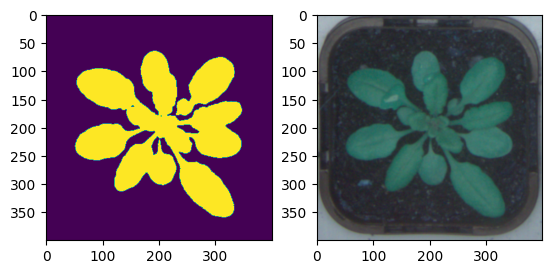

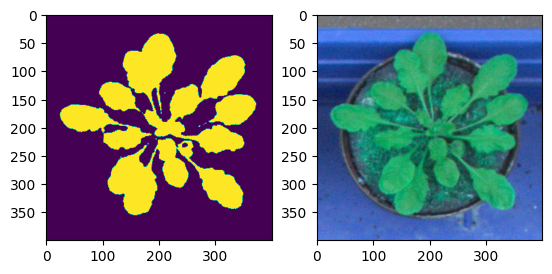

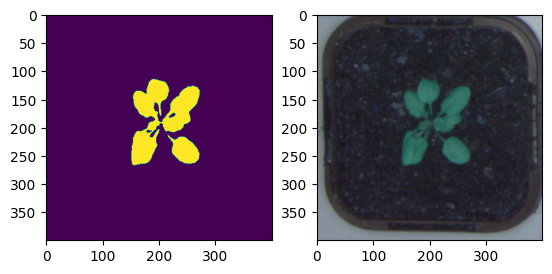

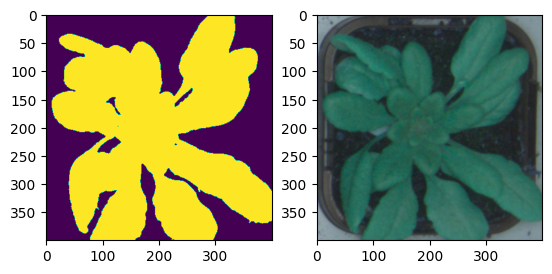

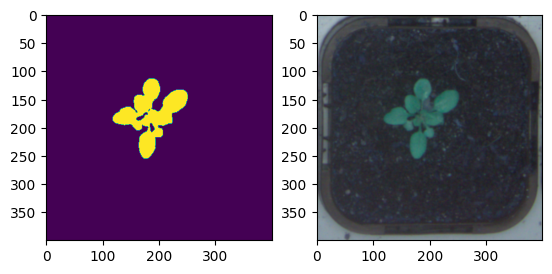

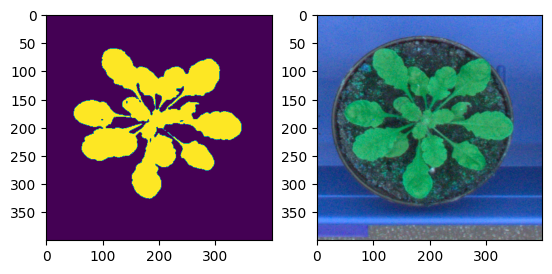

In [ ]:
model = ssm.UNet(3, 1, 10)
model.load_state_dict(torch.load("state150.pth")["model"])

test_loader = DataLoader(
        test_dataset,
        batch_size=6,
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

image = next(iter(test_loader))[0].to(torch.float32).to("cpu", non_blocking=True)

model.eval()
res = torch.nn.Sigmoid()(model(image))
for i in range(6):
    plt.subplot(1,2,1)
    plt.imshow(((res[i]) > 0.6).T.detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(image[i].T.to(int).detach().numpy())
    plt.show()

Посчитаем качество на тесте

In [ ]:
model.to(device)
criterion = nn.BCEWithLogitsLoss().to(params["device"])
test_loss, test_dice, test_mse = eval(test_loader, model, criterion, params)
print('Test Dice: ', test_dice)
print('Test MSE: ', test_mse)

Test Dice:  0.9592306493381745
Test MSE:  0.002239720511531073
